In [1]:
import torch
from vcsmc import *

data_dir = "data/plot_q"

args: TrainArgs = torch.load(
    f"{data_dir}/args.pt", weights_only=False, map_location="cpu"
)
checkpoint: TrainCheckpoint = torch.load(
    f"{data_dir}/checkpoint.pt", weights_only=False, map_location="cpu"
)

In [2]:
vcsmc = checkpoint["vcsmc"]
q_matrix_decoder = vcsmc.q_matrix_decoder
distance = vcsmc.q_matrix_decoder.distance
seq_encoder = vcsmc.proposal.seq_encoder

/var/folders/wg/fdc2whdj45nbl0l947cp4bzh0000gn/T/ipykernel_37215/3721255637.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.15, 0.15, 0.85, 0.85])  # type: ignore


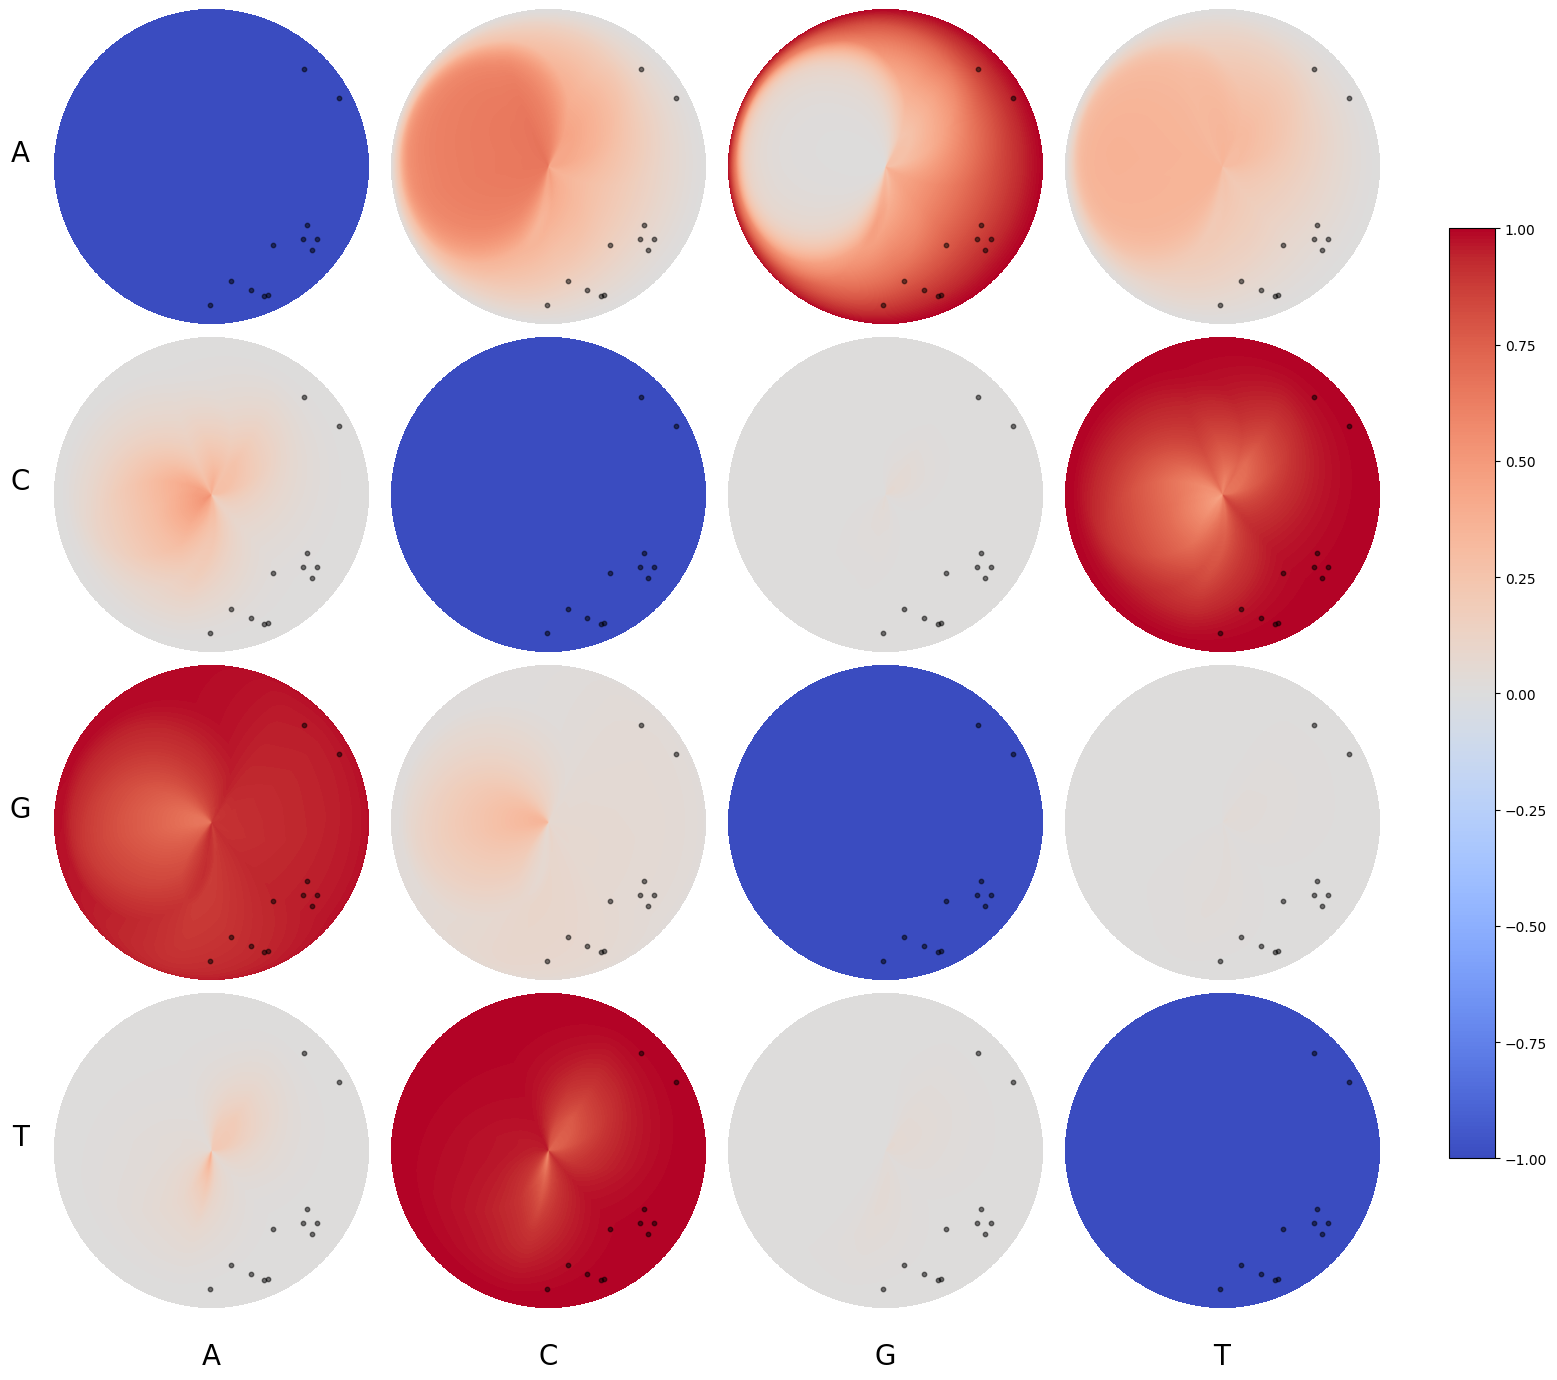

In [3]:
import matplotlib.pyplot as plt

A = 4
B = 1000 + 1  # fidelity of the mesh over the poincare disk

x = torch.linspace(-1, 1, B)
y = torch.linspace(-1, 1, B)

X, Y = torch.meshgrid(x, y, indexing="ij")

mask = torch.where(X**2 + Y**2 <= 1, 1, 0)
mask = mask[:, :, None, None]

X_flat = X.flatten()
Y_flat = Y.flatten()

embeddings = torch.stack([X_flat, Y_flat], dim=1)
embeddings = distance.unnormalize(embeddings)

S = 898
Q = q_matrix_decoder.Q_matrix_VxSxAxA(embeddings, torch.zeros(S, 0))
Q = Q[:, 0]

# B x B x A x A
Q = Q.view(B, B, A, A)

# mask
Q = torch.where(mask == 1, Q, torch.tensor(float("nan")))

vmin = -1
vmax = 1

# (number of taxa) x 2
embeddings = seq_encoder(args["data_NxSxA"])
embeddings = distance.normalize(embeddings)

n_rows = 4
n_cols = 4

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))

for row in range(n_rows):
    for col in range(n_cols):
        ax = axs[row, col]  # type: ignore
        cax = ax.imshow(
            Q[:, :, row, col].detach().numpy(), cmap="coolwarm", vmin=vmin, vmax=vmax
        )

        ax.scatter(
            (embeddings[:, 0].detach().numpy() + 1) * (B - 1) / 2,
            (embeddings[:, 1].detach().numpy() + 1) * (B - 1) / 2,
            color="black",
            s=10,
            alpha=0.5,
        )

        ax.spines["left"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.tick_params(axis="x", which="both", length=0)
        ax.tick_params(axis="y", which="both", length=0)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        alphabet = list(A4_ALPHABET.keys())

        if row == n_rows - 1:
            ax.set_xlabel(alphabet[col], fontsize=20, labelpad=20)

        if col == 0:
            ax.set_ylabel(alphabet[row], rotation=0, fontsize=20, labelpad=20)


fig.colorbar(cax, ax=axs, orientation="vertical", fraction=0.03)  # type: ignore
plt.tight_layout(rect=[0.15, 0.15, 0.85, 0.85])  # type: ignore

plt.savefig("output/q_matrix.pdf")
plt.show()

# TODO
# - label for overall x and y axis (interpretation of the Q matrix)